In [1]:
from __future__ import print_function

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../MNIST-data", False, one_hot=True)

/opt/Anaconda/envs/tensorflow1.5/lib/python3.5/site-packages/scipy/__init__.py:144: UserWarning: Numpy 1.13.3 or above is required for this version of scipy (detected version 1.13.1)
  UserWarning)


Extracting ../MNIST-data/train-images-idx3-ubyte.gz
Extracting ../MNIST-data/train-labels-idx1-ubyte.gz
Extracting ../MNIST-data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST-data/t10k-labels-idx1-ubyte.gz


In [2]:
# Parameters
learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1
logs_path = '/tmp/tensorflow_logs/example/'

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y = tf.placeholder(tf.float32, [None, 10], name='LabelData')

In [3]:
# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Create a summary to visualize the first layer ReLU activation
    tf.summary.histogram("relu1", layer_1)
    
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Create another summary to visualize the second layer ReLU activation
    tf.summary.histogram("relu2", layer_2)
    
    # Output layer
    out_layer = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    
    return out_layer

# Store layers weight & bias
weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1]), name='W1'),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name='W2'),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, n_classes]), name='W3')
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_hidden_2]), name='b2'),
    'b3': tf.Variable(tf.random_normal([n_classes]), name='b3')
}

In [4]:
# Encapsulating all ops into scopes, making Tensorboard's Graph
# Visualization more convenient
with tf.name_scope('Model'):
    # Build model
    pred = multilayer_perceptron(x, weights, biases)

with tf.name_scope('Loss'):
    # Softmax Cross entropy (cost function)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    
    # Op to calculate every variable gradient
    grads = tf.gradients(loss, tf.trainable_variables())
    grads = list(zip(grads, tf.trainable_variables()))
    
    # Op to update all variables according to their gradient
    apply_grads = optimizer.apply_gradients(grads_and_vars=grads)

with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [5]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)

# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc)

# Create summaries to visualize weights
# 直方图
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
    
# Summarize all gradients
for grad, var in grads:
    tf.summary.histogram(var.name + '/gradient', grad)
    
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

INFO:tensorflow:Summary name W1:0 is illegal; using W1_0 instead.
INFO:tensorflow:Summary name W2:0 is illegal; using W2_0 instead.
INFO:tensorflow:Summary name W3:0 is illegal; using W3_0 instead.
INFO:tensorflow:Summary name b1:0 is illegal; using b1_0 instead.
INFO:tensorflow:Summary name b2:0 is illegal; using b2_0 instead.
INFO:tensorflow:Summary name b3:0 is illegal; using b3_0 instead.
INFO:tensorflow:Summary name W1:0/gradient is illegal; using W1_0/gradient instead.
INFO:tensorflow:Summary name W2:0/gradient is illegal; using W2_0/gradient instead.
INFO:tensorflow:Summary name W3:0/gradient is illegal; using W3_0/gradient instead.
INFO:tensorflow:Summary name b1:0/gradient is illegal; using b1_0/gradient instead.
INFO:tensorflow:Summary name b2:0/gradient is illegal; using b2_0/gradient instead.
INFO:tensorflow:Summary name b3:0/gradient is illegal; using b3_0/gradient instead.


In [6]:
# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path,
                                           graph=tf.get_default_graph())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([apply_grads, loss, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys})
            
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if (epoch + 1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    # Calculate accuracy
    print("Accuracy:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))

Epoch: 0001 cost= 64.847319239
Epoch: 0002 cost= 11.997898542
Epoch: 0003 cost= 7.414121253
Epoch: 0004 cost= 5.288535645
Epoch: 0005 cost= 4.010358028
Epoch: 0006 cost= 3.179781527
Epoch: 0007 cost= 2.575792213
Epoch: 0008 cost= 2.122923202
Epoch: 0009 cost= 1.780423388
Epoch: 0010 cost= 1.515472660
Epoch: 0011 cost= 1.308742742
Epoch: 0012 cost= 1.130350541
Epoch: 0013 cost= 0.989404083
Epoch: 0014 cost= 0.855569732
Epoch: 0015 cost= 0.761519032
Epoch: 0016 cost= 0.669976670
Epoch: 0017 cost= 0.593950818
Epoch: 0018 cost= 0.544423419
Epoch: 0019 cost= 0.476591290
Epoch: 0020 cost= 0.426571090
Epoch: 0021 cost= 0.383029294
Epoch: 0022 cost= 0.345376255
Epoch: 0023 cost= 0.314063420
Epoch: 0024 cost= 0.287937227
Epoch: 0025 cost= 0.260920715
Optimization Finished!
Accuracy: 0.9239


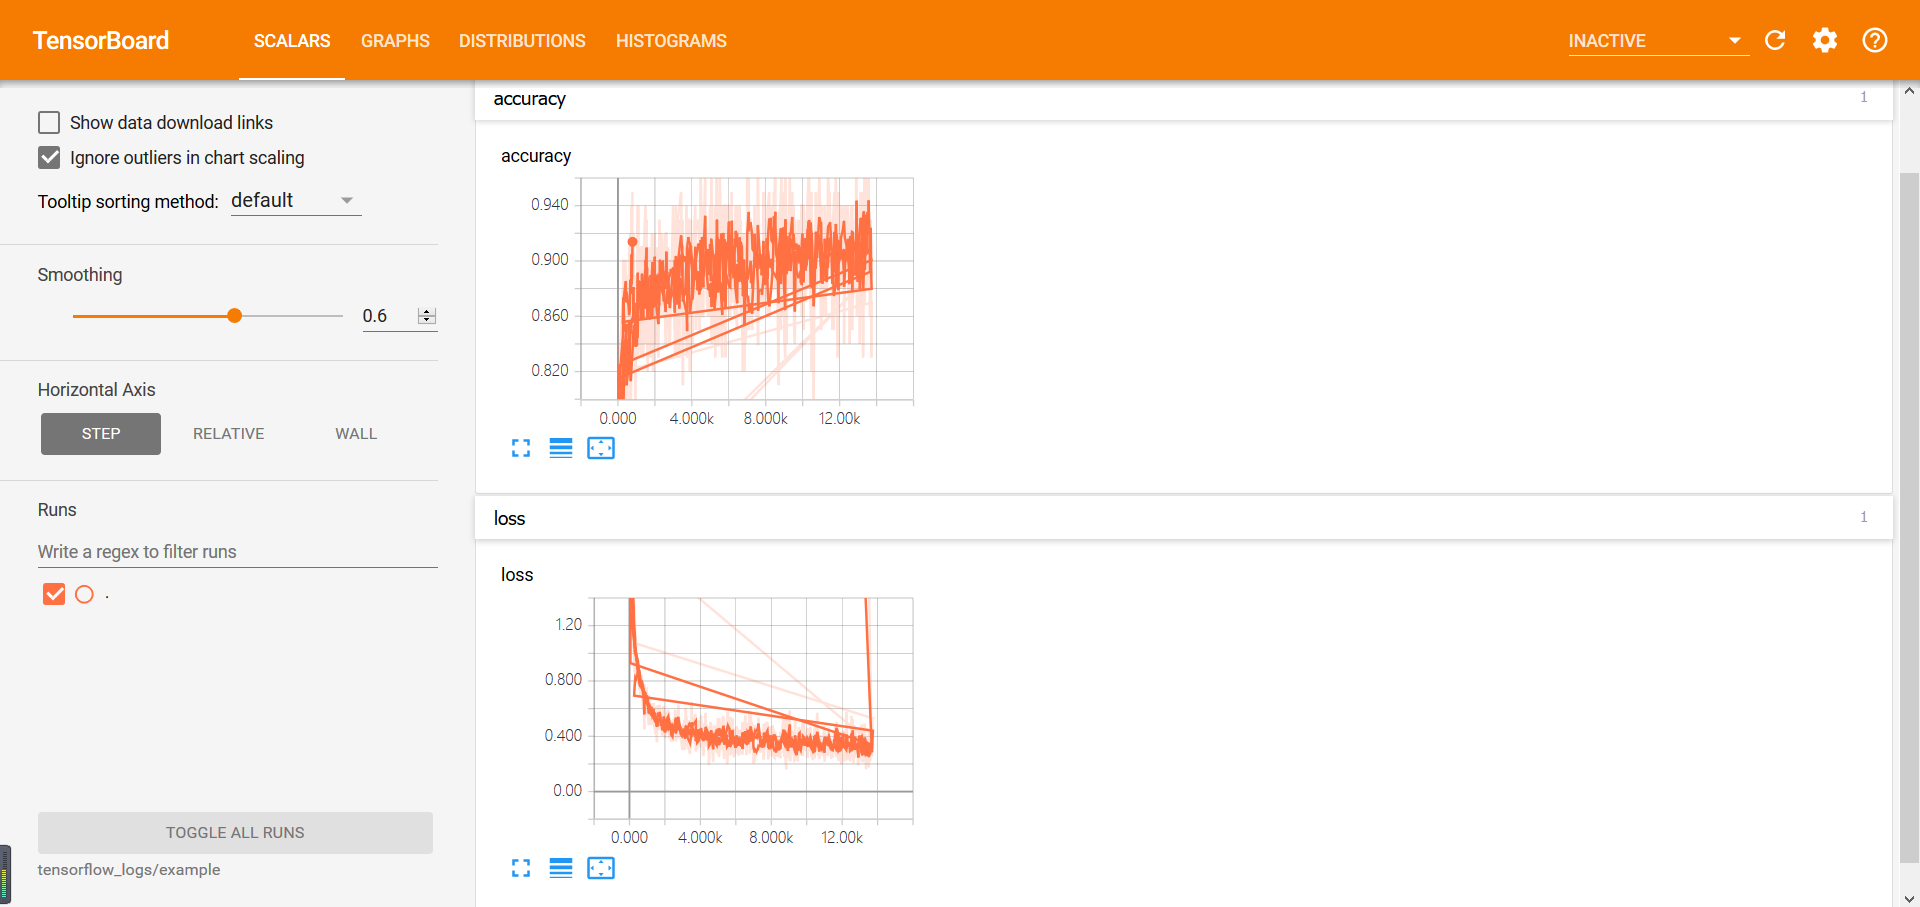

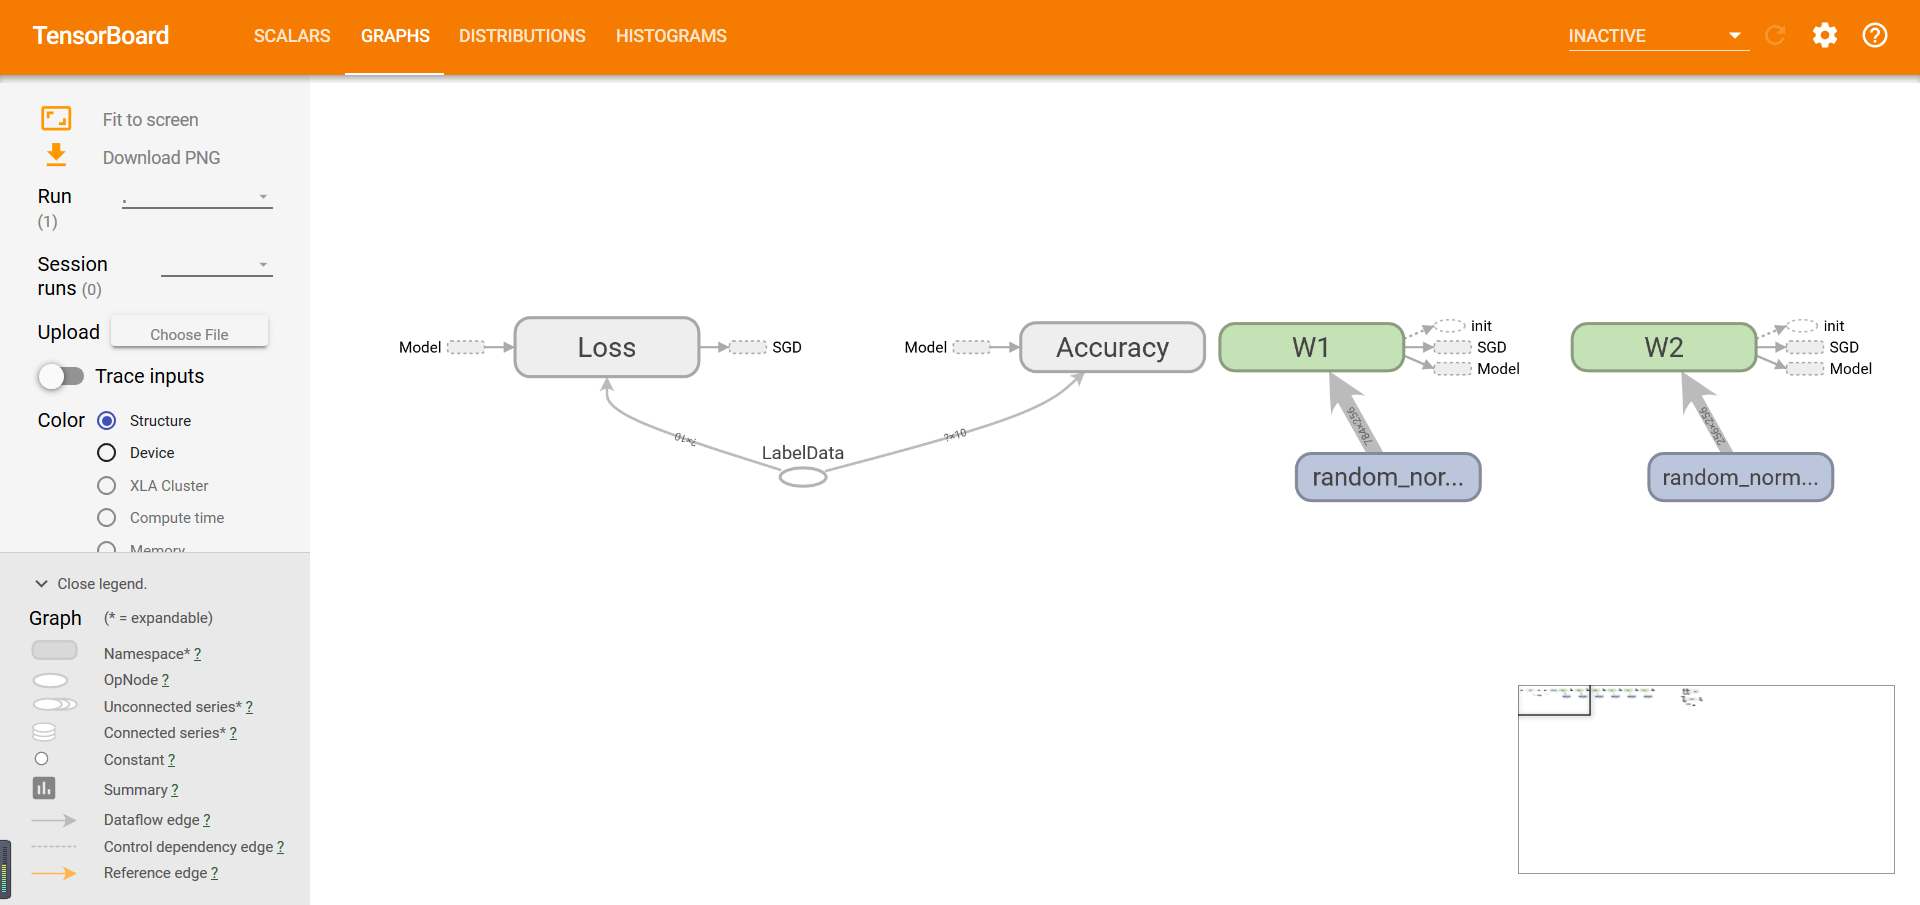

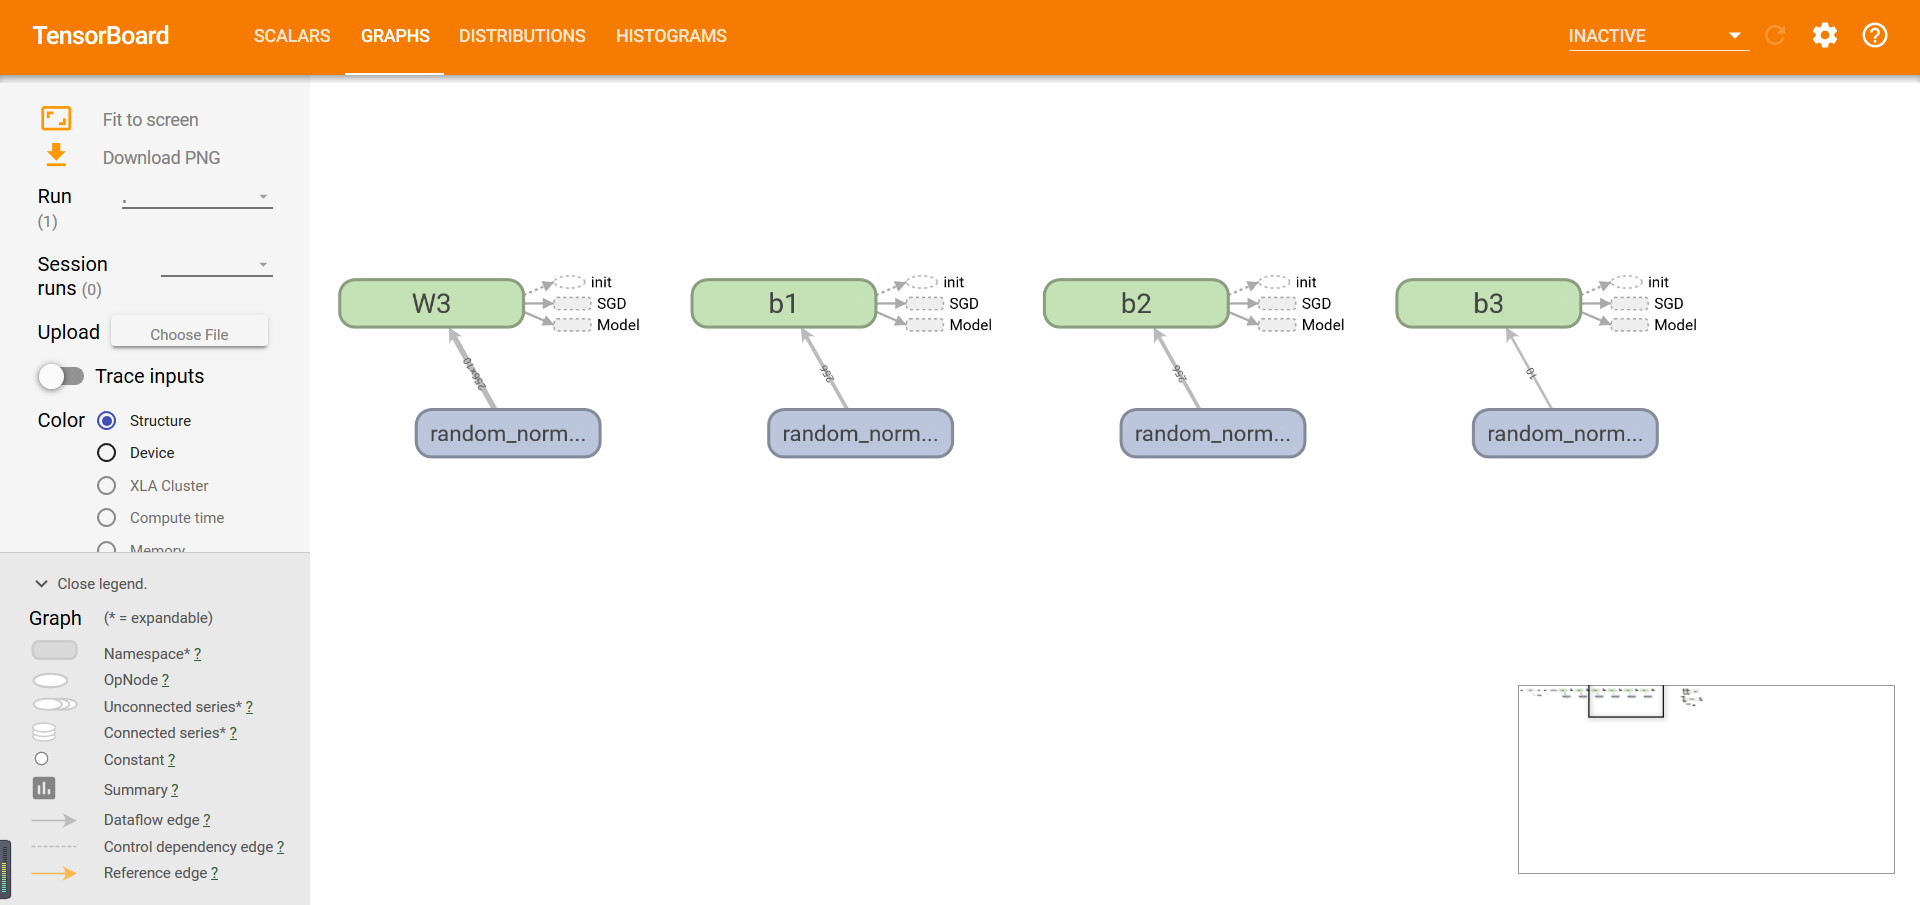

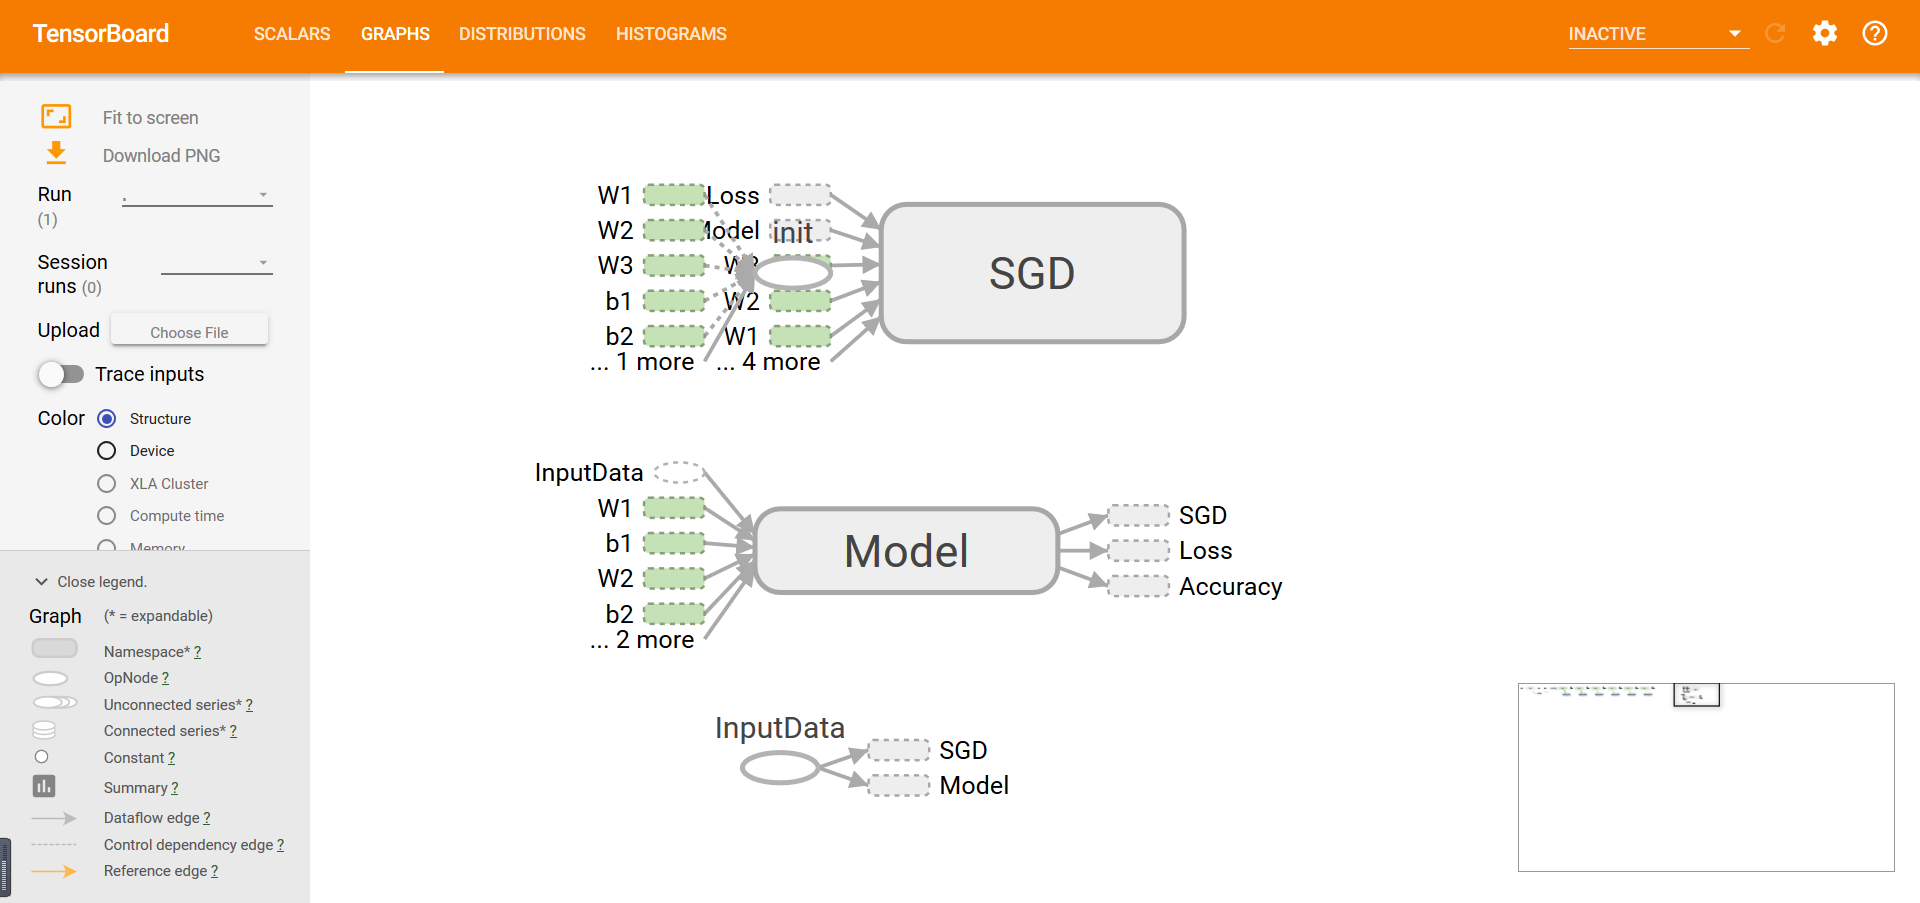

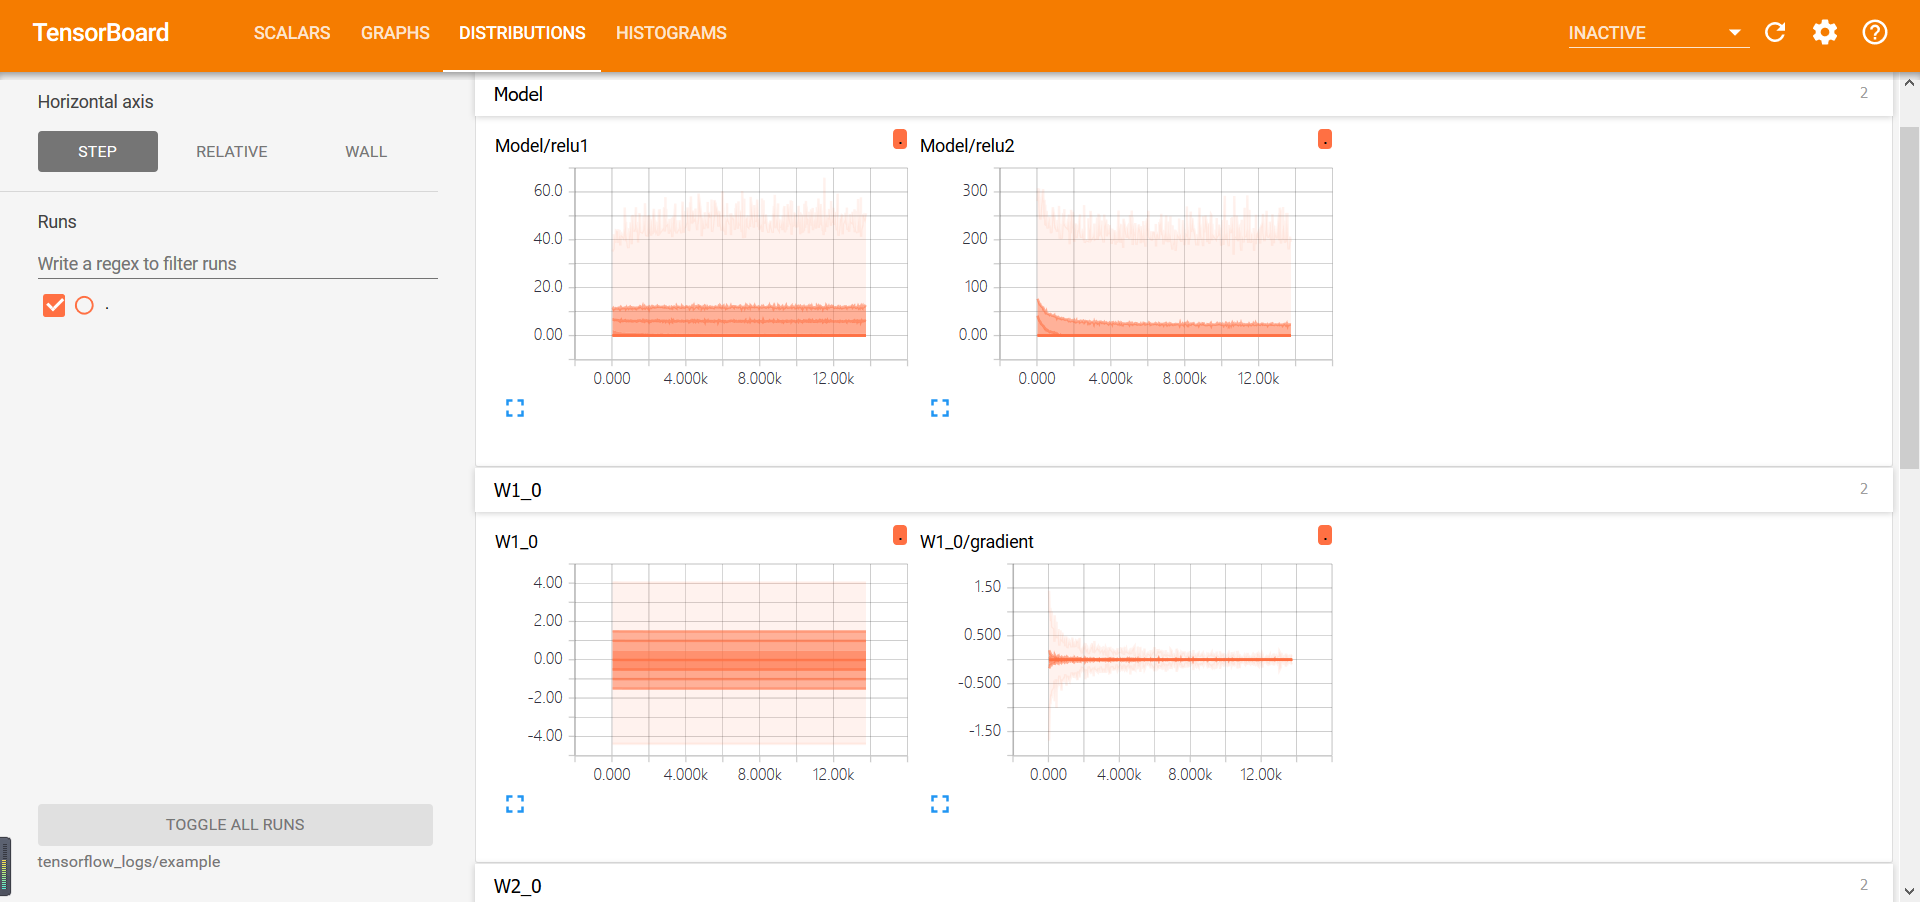

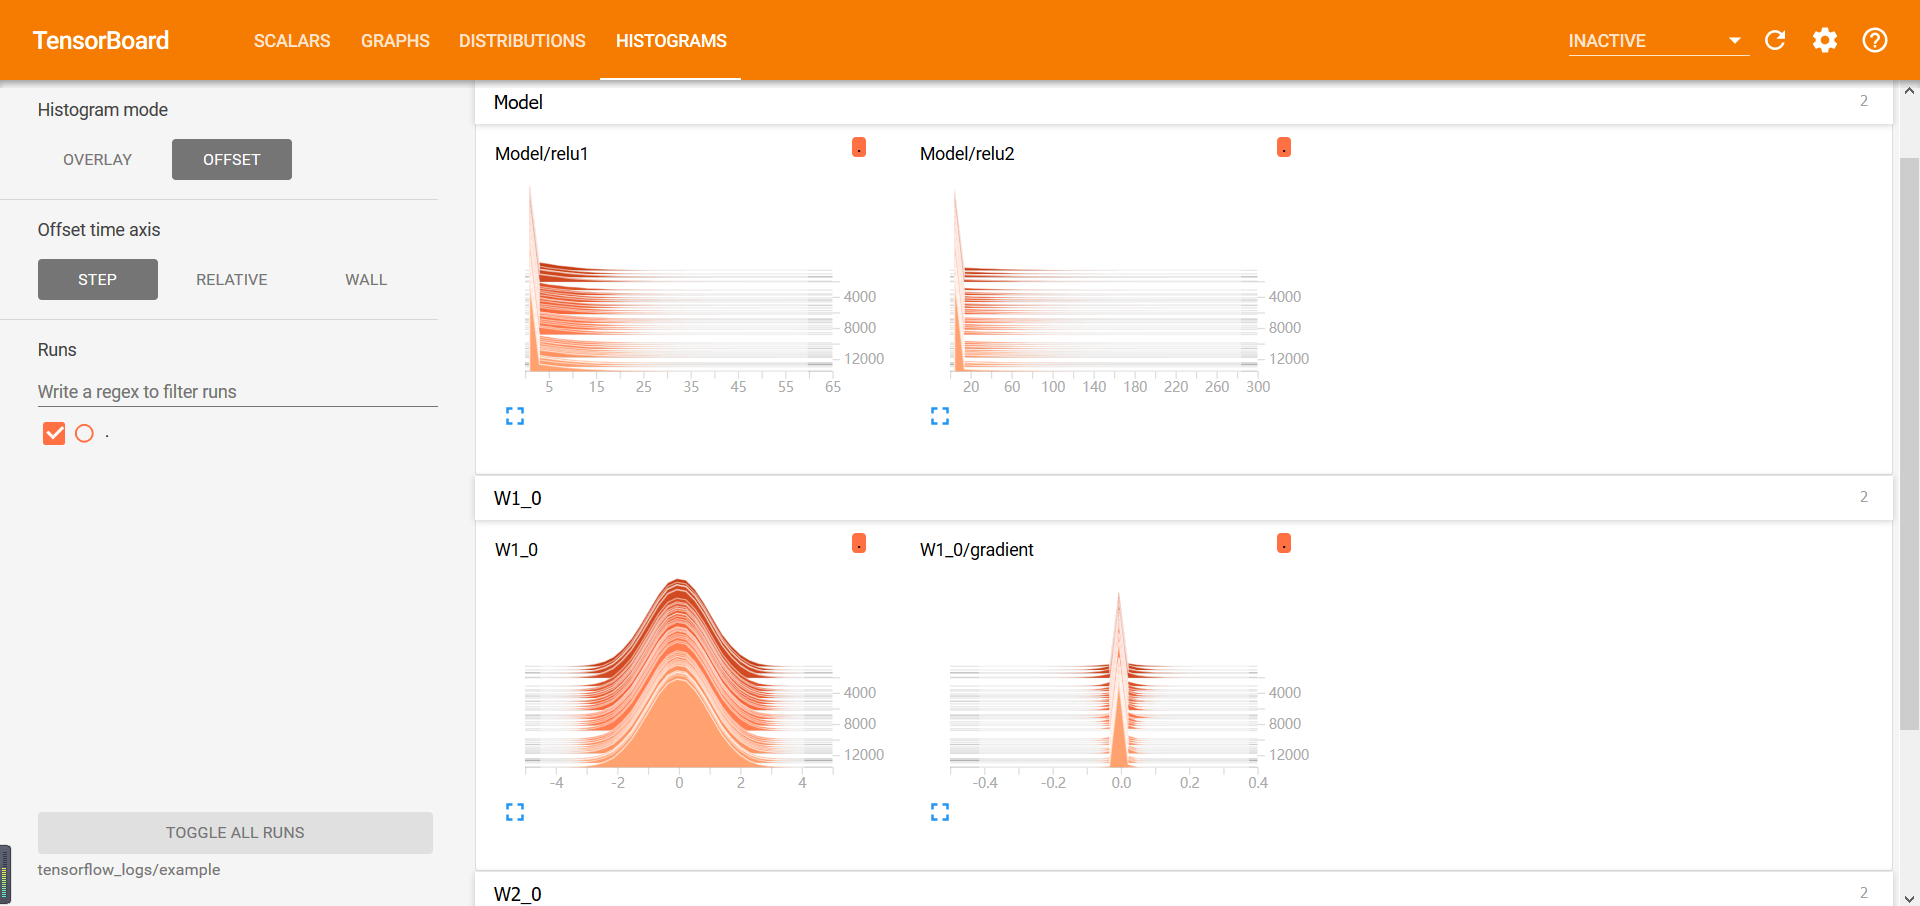